In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Exchange Rates'}, xlabel='Date'>

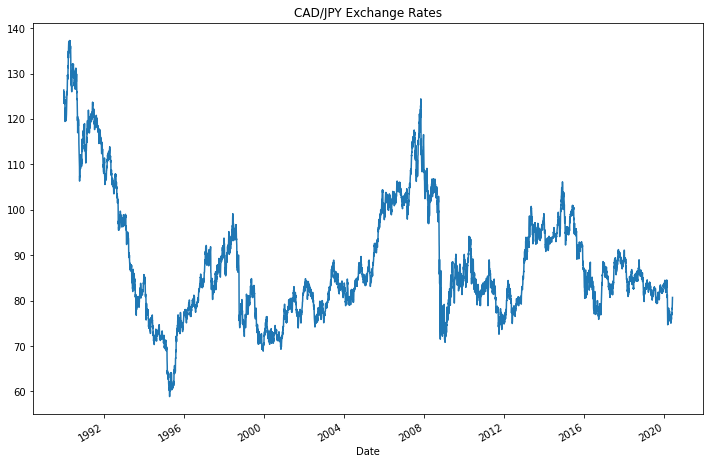

In [4]:
# Plot just the "Price" column from the dataframe:
# YOUR CODE HERE!
cad_jpy_df['Price'].plot(
    title='CAD/JPY Exchange Rates',
    figsize=(12,8)
)

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:**

In 1990 the start of this graph there is a significant drop in price, by the end of 1990's there is a slight uptrend. 

In the short term from year 2000 to 2008 there is a increasing upward trend, with slightly bigger peaks and valleys, compared to the previous decade.

In the long term, there are volatility abound. There are also periods of sharp decline and a long-standing uptrends. We can see a downward trend and that the time series is non-stationary.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
# YOUR CODE HERE!
yen_noise, yen_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])


In [6]:
yen_noise, yen_trend

(Date
 1990-01-02    0.519095
 1990-01-03   -0.379684
 1990-01-04   -2.048788
 1990-01-05   -0.798304
 1990-01-08   -0.897037
                 ...   
 2020-05-29   -0.503961
 2020-06-01    0.218939
 2020-06-02    1.088117
 2020-06-03    1.125501
 2020-06-04    0.872339
 Name: Price_cycle, Length: 7929, dtype: float64,
 Date
 1990-01-02    125.850905
 1990-01-03    125.679684
 1990-01-04    125.508788
 1990-01-05    125.338304
 1990-01-08    125.167037
                  ...    
 2020-05-29     78.793961
 2020-06-01     79.051061
 2020-06-02     79.311883
 2020-06-03     79.574499
 2020-06-04     79.837661
 Name: Price_trend, Length: 7929, dtype: float64)

In [7]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
exchange_rate_price_df = pd.DataFrame({
    "Price": cad_jpy_df['Price'], 
    "noise": yen_noise, 
    "trend": yen_trend}
)

exchange_rate_price_df.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

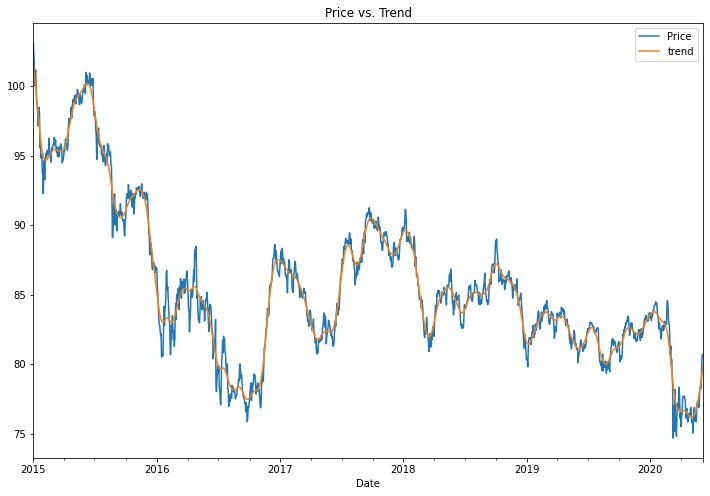

In [8]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
exchange_rate_price_df[['Price', 'trend']].loc['2015':].plot(
    fontsize = 10,  
    figsize=(12,8), 
    title='Price vs. Trend'
)

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** 

There is an overall long-term downtrend decline, since the peak of 2016.
Short-term there is constant volitility that the slight upward trends revert quickly to downward trends.


<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

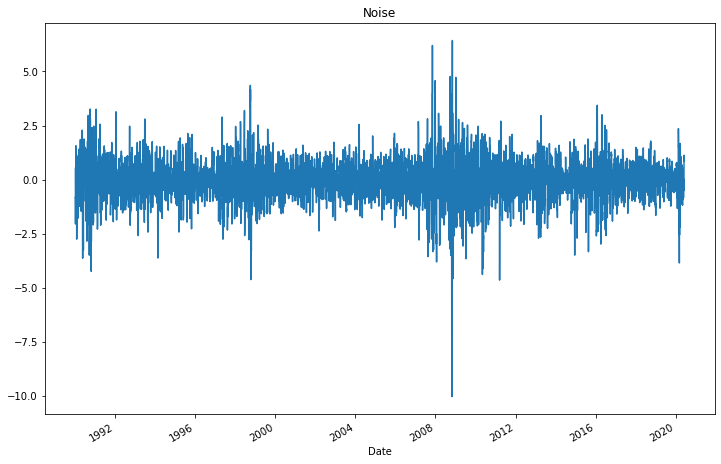

In [9]:
# Plot the Settle Noise
# YOUR CODE HERE!
exchange_rate_price_df['noise'].plot(figsize=(12,8),title='Noise')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [11]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [12]:
# unit 10/w2/03-Ins_ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model = sm.tsa.arima.ARIMA(returns.values, order=(2,0,1))


In [13]:
# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results = model.fit()

In [14]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -9752.310
Date:                Tue, 31 May 2022   AIC                          19514.620
Time:                        21:00:09   BIC                          19549.511
Sample:                             0   HQIC                         19526.568
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.237      0.813      -0.021       0.016
ar.L1         -0.0152      3.499     -0.004      0.997      -6.873       6.843
ar.L2         -0.0018      0.107     -0.017      0.987      -0.212       0.209
ma.L1         -0.0153      3.499     -0.004      0.997      -6.874       6.844
sigma2         0.6855      0.006    122.678      0.000       0.675       0.696
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11578.41
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

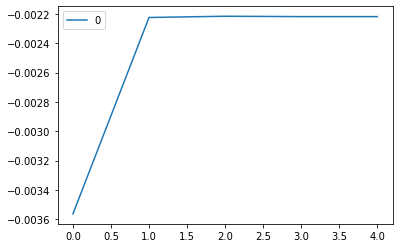

In [15]:
results = results.forecast(steps = 5, exog=None, alpha=0.05)
pd.DataFrame(results).plot()

In [16]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
#pd.DataFrame(results.forecast(steps=5)).plot(figsize = (15,6), title="5 Day Futures Price Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Since our p-value >α, we can determine that the model is not a good fit. Specifically, in this case, 0.85 > 0.5, thus p-value >α.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [17]:
from statsmodels.tsa.arima_model import ARIMA

In [18]:
model = sm.tsa.arima.ARIMA(cad_jpy_df['Price'], order=(5, 1, 1))
results = model.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7929
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.898
Date:                Tue, 31 May 2022   AIC                          17505.796
Time:                        21:00:19   BIC                          17554.643
Sample:                             0   HQIC                         17522.523
                               - 7929                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4303      0.331      1.299      0.194      -0.219       1.080
ar.L2          0.0178      0.012      1.459      0.145      -0.006       0.042
ar.L3         -0.0118      0.009     -1.313      0.189      -0.029       0.006
ar.L4          0.0110      0.008      1.299      0.194      -0.006       0.028
ar.L5         -0.0191      0.007     -2.706      0.007      -0.033      -0.005
ma.L1         -0.4583      0.332     -1.380      0.167      -1.109       0.192
sigma2         0.5318      0.004    118.418      0.000       0.523       0.541
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9233.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:>

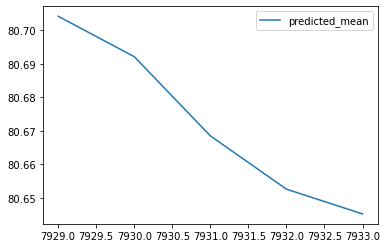

In [20]:
results = results.forecast(steps = 5, exog=None, alpha=0.05)
pd.DataFrame(results).plot()

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** My model predicts that Yen will weaken in the near term. The plot titled "5 Day Futures Price Forecast" clearly shows a significant decline.


---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [21]:
!pip install arch
import arch as arch
from arch import arch_model

In [22]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 306850859.3384427
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838861417698
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11771.663036006626
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.31072801688
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.369930732108
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.112105819691
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027322298947
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.022077988246
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021067661106
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020797453917
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764880363
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.020764882265
Optimization terminated successfully    (Exit mode 0)
         

In [23]:
# Summarize the model results
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Tue, May 31 2022   Df Residuals:                     7928
Time:                        21:03:12   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [24]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [25]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [26]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [27]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:title={'center':'Volatility: 5-day Forecast'}>

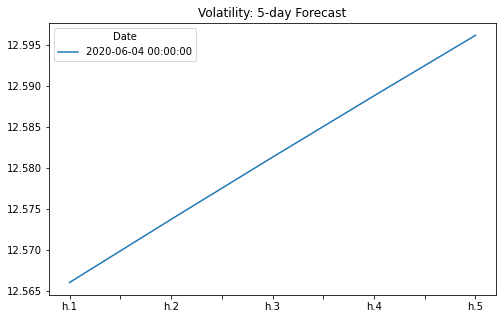

In [28]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(figsize=(8,5), title="Volatility: 5-day Forecast")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** The model indicates that the volatility will increase in the near term. The five day forecast clearly shows the increase from h1 to h5.

The model predicts that the volatility will be increasing with a constant rate.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * The high volatility of the Yen indicated by the GARCH model, no not good time to buy.


2. Is the risk of the yen expected to increase or decrease?
    * In the short term the risk of the yen is expected to increase

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * This model has determinied a weak model based of p-value >α. Thus requires more modifications and calibrations to be fit for trading purposes. The inacurate models has only one thing to predict with confidence that is the volatility of the Yen will increase within the next 5 days. 